In [11]:
# imports
from anndata import AnnData
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from umap import UMAP
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import scanpy as sc
from embed import read_tcga
# from molecular_cross_validation.mcv_sweep import GridSearchMCV


## Load data

In [12]:
adata = read_tcga()
adata = sc.pp.filter_genes(adata, min_cells=1)

Reading data/TCGA.HNSC.expression.txt...
Reading data/TCGA.HNSC.metadata.txt...
Creating AnnData object...


## Select optimal number of dimensions using Molecular Cross Validation (MCV) method

Preprint: <https://www.biorxiv.org/content/10.1101/786269v1.full#F4>

GitHub <https://github.com/czbiohub/molecular-cross-validation>

In [6]:
def recipe(adata):
    sc.pp.log1p(adata)
    sc.pp.scale(adata, max_value=10, zero_center=False)
    return adata

def mcv(adata, recipe, model, max_components = 30):

    # convert to int64
    if adata.X.dtype != np.int64:
        adata.X = adata.X.astype(np.int64)

    # split the data in half
    adata1 = adata.copy()
    adata2 = adata.copy()
    adata1.X = np.random.binomial(adata.X, 0.5).astype(float)
    adata2.X = adata.X - adata1.X
    
    # normalize and scale each split
    adata = recipe(adata)
    adata1 = recipe(adata1)
    adata2 = recipe(adata2)
    
    # setup output 
    k_range = np.arange(2, max_components, 2)
    mcv_loss = np.zeros(len(k_range))
    rec_loss = np.zeros(len(k_range))
    gt_loss = np.zeros(len(k_range))
        
    for i, k in enumerate(k_range):
        # fit model
        fit = model(n_components=k).fit(adata1.X)
        
        # transform data
        trans = fit.transform(adata1.X)
        reconstruction = fit.inverse_transform(trans)
        rec_loss[i] = mean_squared_error(reconstruction, adata1.X)
        mcv_loss[i] = mean_squared_error(reconstruction, adata2.X)
        gt_loss[i] = mean_squared_error(reconstruction, adata.X)

    return pd.DataFrame({'k': k_range, 'mcv_loss': mcv_loss, 'rec_loss': rec_loss, 'gt_loss': gt_loss})

<Axes: xlabel='k', ylabel='MSE'>

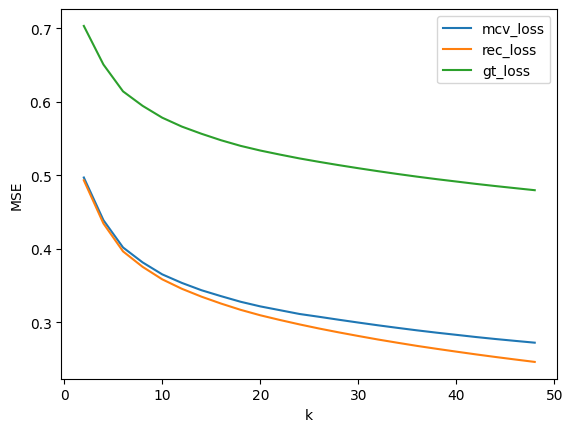

In [4]:
res = mcv(adata.copy(), recipe, PCA, max_components = 50)
fig = sns.lineplot(x='k', y='MSE', hue='variable', data=pd.melt(res, ['k'], var_name='variable', value_name='MSE'))
fig.legend_.set_title(None)


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


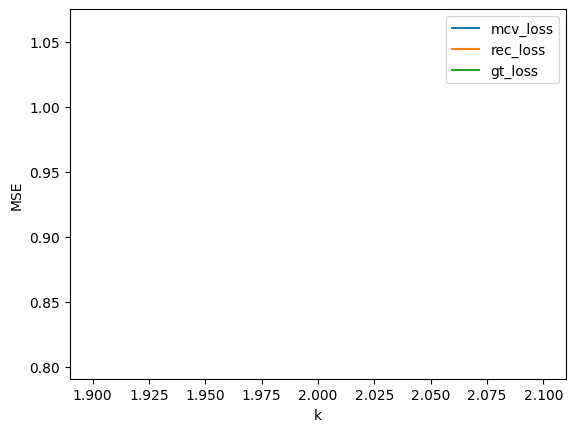

In [9]:
res = mcv(adata.copy(), recipe, UMAP, max_components = 4)
fig = sns.lineplot(x='k', y='MSE', hue='variable', data=pd.melt(res, ['k'], var_name='variable', value_name='MSE'))
fig.legend_.set_title(None)